In [2]:
import numpy as np
from matplotlib import pyplot as plt
import glob

In [8]:
def generate_ash_map_from_btd(array,threshold):
    new_array = np.zeros(array.shape)
    ash_pixels = np.where(array <= threshold)
    rs = ash_pixels[0]
    cs = ash_pixels[1]
    for i,r in enumerate(rs):
        new_array[rs[i], cs[i]] = 1
    return new_array

def generate_ash_map_from_prob(array, threshold):
    new_array = np.zeros(array.shape)
    ash_pixels = np.where(array >= threshold)
    rs = ash_pixels[0]
    cs = ash_pixels[1]
    for i,r in enumerate(rs):
        new_array[rs[i], cs[i]] = 1
    return new_array

def false_rates(test_array,true_array):
    positives = (true_array == 1.0).sum()
    negatives = (true_array == 0.).sum()
    false_positives = 0
    false_negatives = 0
    shape = np.shape(true_array)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if test_array[i,j] == 1. and true_array[i,j] == 0.:
                false_positives += 1
            if test_array[i,j] == 0. and true_array[i,j] == 1.:
                false_negatives += 1
    f_pos_rate = false_positives/negatives
    f_neg_rate = false_negatives/positives
    return f_pos_rate, f_neg_rate, false_positives, false_negatives

def iou_loss(test_array,true_array):
    positives = (true_array == 1.0).sum()
    negatives = (true_array == 0.).sum()
    true_positives = 0
    union_positives = 0
    shape = np.shape(true_array)
    for i in range(shape[0]):
        for j in range(shape[1]):
            if test_array[i,j] == 1. and true_array[i,j] == 1.:
                true_positives += 1
            if test_array[i,j] == 1. or true_array[i,j] == 1.:
                union_positives += 1
    iou_loss = 1 - true_positives/(union_positives)
    return iou_loss

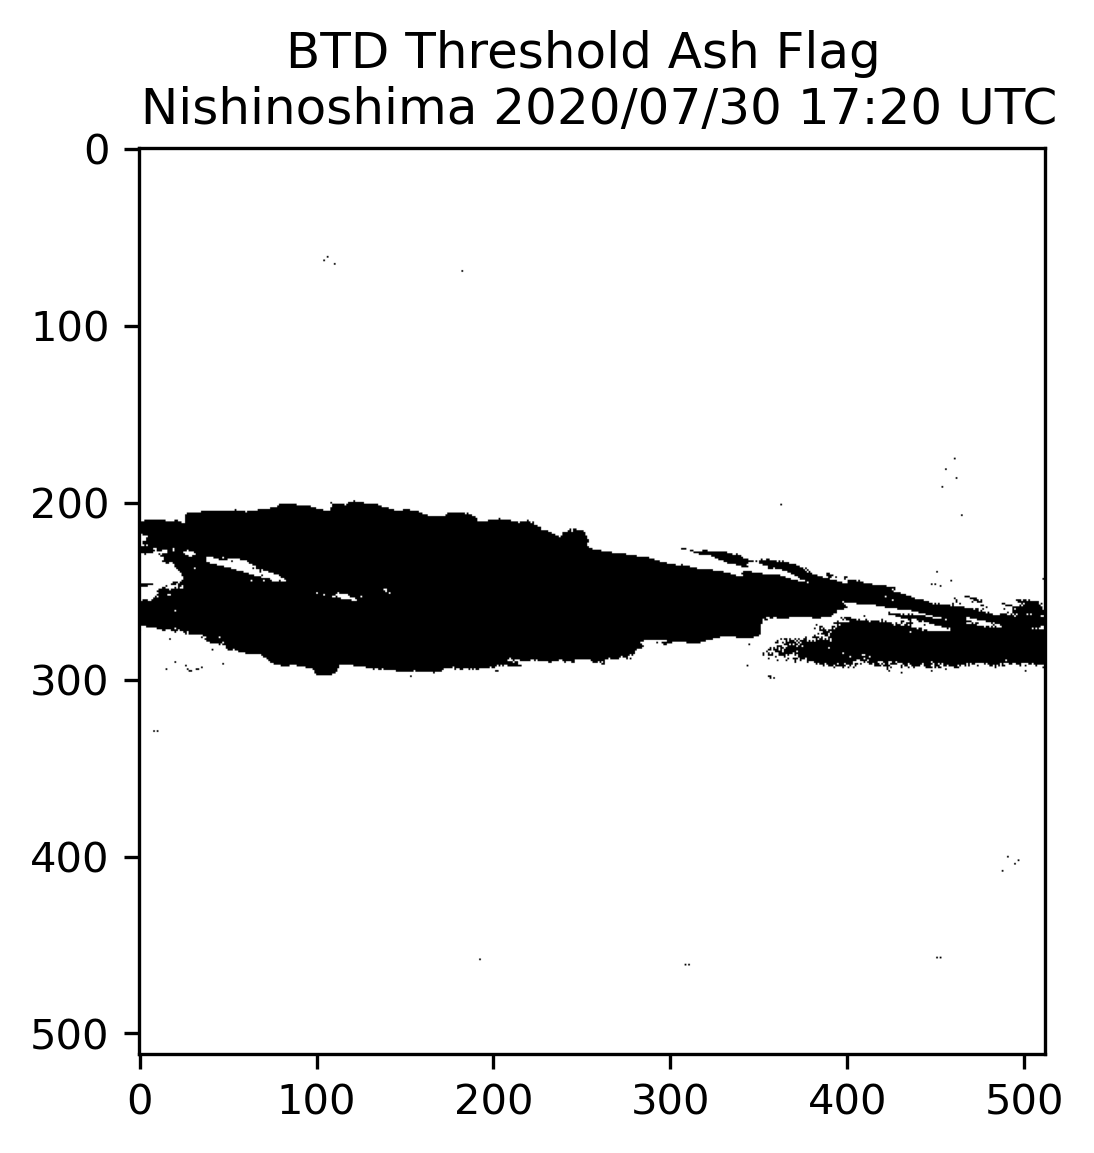

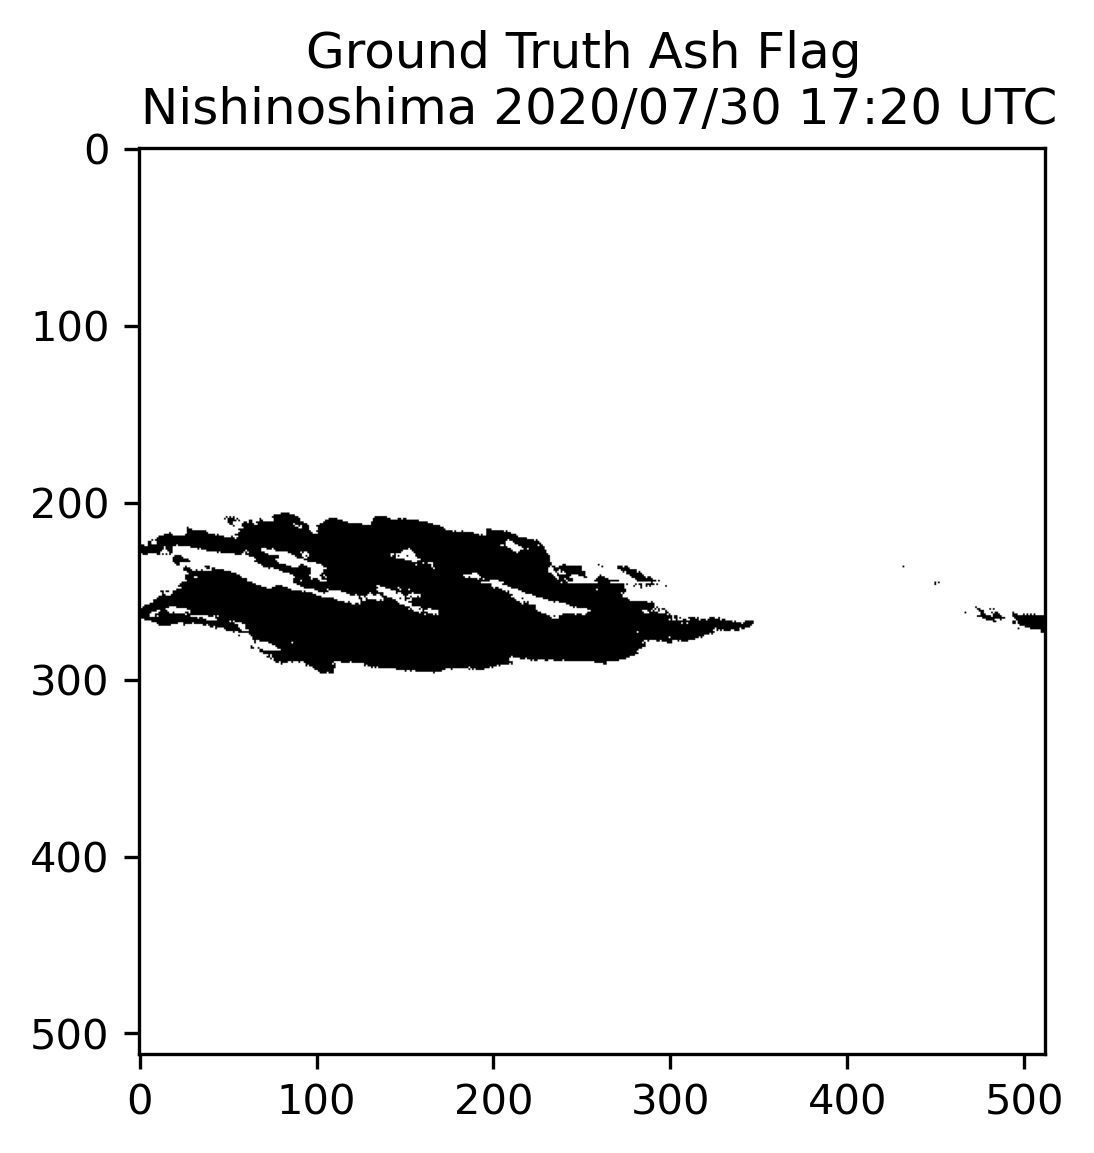

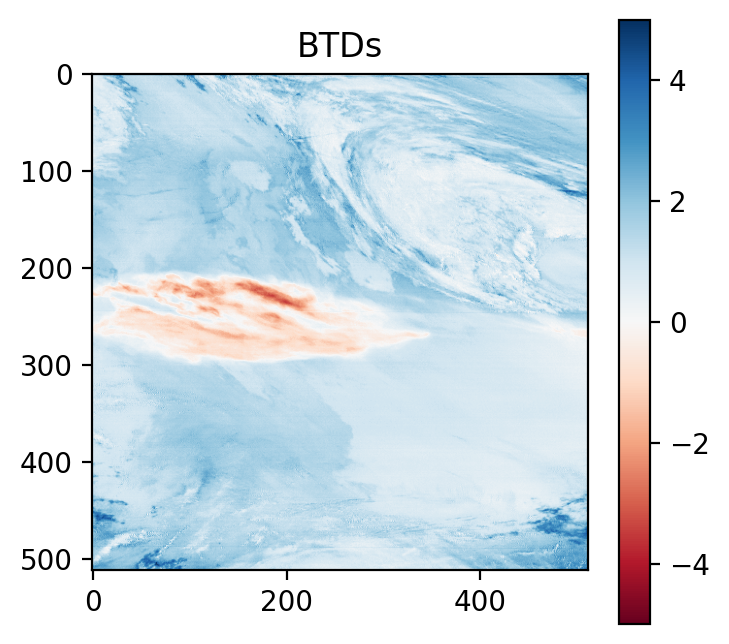

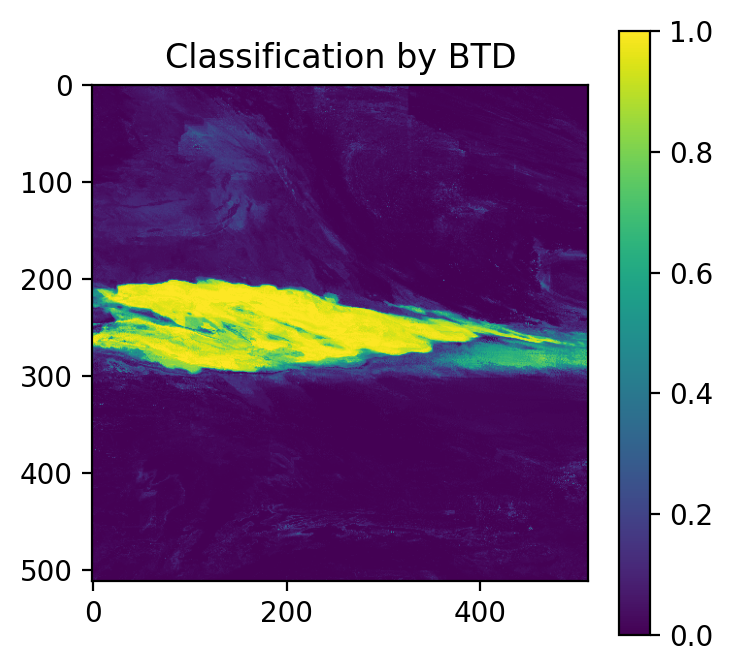

In [106]:

my_array = np.load("E:\\RAIKOKE\\PAPER_IMAGES\\classify_2_RAIKOKE-20190622_1120_RF_7_r_8_depth_20_ests_64_with_raikoke.sav_corrected.png.npy")
my_true_array_load = np.load("E:\\RAIKOKE\\PAPER_ARRAYS\\RAIKOKE-20190622_1120.npy")
my_true_array_load_masked = (my_true_array_load[:,:,13]-my_true_array_load[:,:,14]) * my_true_array_load[:,:,16] # - np.exp(6. * (my_true_array_load[:,:,13] / 305) - (6-np.log(2.9)))) *my_true_array_load[:,:,16]
my_true_array = generate_ash_map_from_btd(my_true_array_load_masked,-0.01)
#my_array = (my_true_array_load[:,:,13]-my_true_array_load[:,:,14]) # - np.exp(6. * (my_true_array_load[:,:,13] / 305) - (6-np.log(2.9))))
# for i in range(512):
#     for j in range(512):
#         if my_true_array_load[i,j][13] <= 245:
#             my_true_array[i,j] = 0.0
# for i in range(512):
#     for j in range(512):
#         if my_true_array_load[i,j][13] <= 245:
#             my_array[i,j] = 0.1

#my_true_array = my_true_array_load[:,:,16]
ash_array = generate_ash_map_from_prob(my_array,0.39)
plt.figure(figsize = (4,4), dpi = 300)
plt.imshow(ash_array , cmap = "binary")
plt.title("BTD Threshold Ash Flag \n Nishinoshima 2020/07/30 17:20 UTC")
#plt.savefig("BTD_ash_flag_Nishinoshima.png")


plt.figure(figsize = (4,4), dpi = 300)
plt.title("Ground Truth Ash Flag \n Nishinoshima 2020/07/30 17:20 UTC")
plt.imshow(my_true_array, cmap = "binary")
#plt.savefig("TRUTH_Nishinoshima.png")

plt.figure(figsize = (4,4), dpi = 200)
plt.title("BTDs")
plt.imshow(my_true_array_load[:,:,13]-my_true_array_load[:,:,14], cmap = "RdBu", vmin = -5, vmax = 5)
plt.colorbar()
#plt.savefig("Raikoke_BTD_0_seen.jpg")

plt.figure(figsize=(4,4), dpi = 200)
plt.title("Classification by BTD")
plt.imshow(my_array) # , cmap = "turbo", vmin = 0, vmax = 1)
plt.colorbar()
#plt.savefig("Raikoke_0_seen.jpg")

trial_probs = np.arange(0.01,0.99,0.01)

false_rates_vec = []
for m in range(len(trial_probs)):
    false_rates_vec.append(false_rates(generate_ash_map_from_prob(my_array, trial_probs[m]),my_true_array))
iou_vec = []
for m in range(len(trial_probs)):
    iou_vec.append(iou_loss(generate_ash_map_from_btd(my_array, trial_probs[m]),my_true_array))


False positive rate at 85% threshold: 0.0228
False positive rate at 50% threshold: 0.0458
False negative rate at 85% threshold: 0.2197
False negative rate at 50% threshold: 0.0232


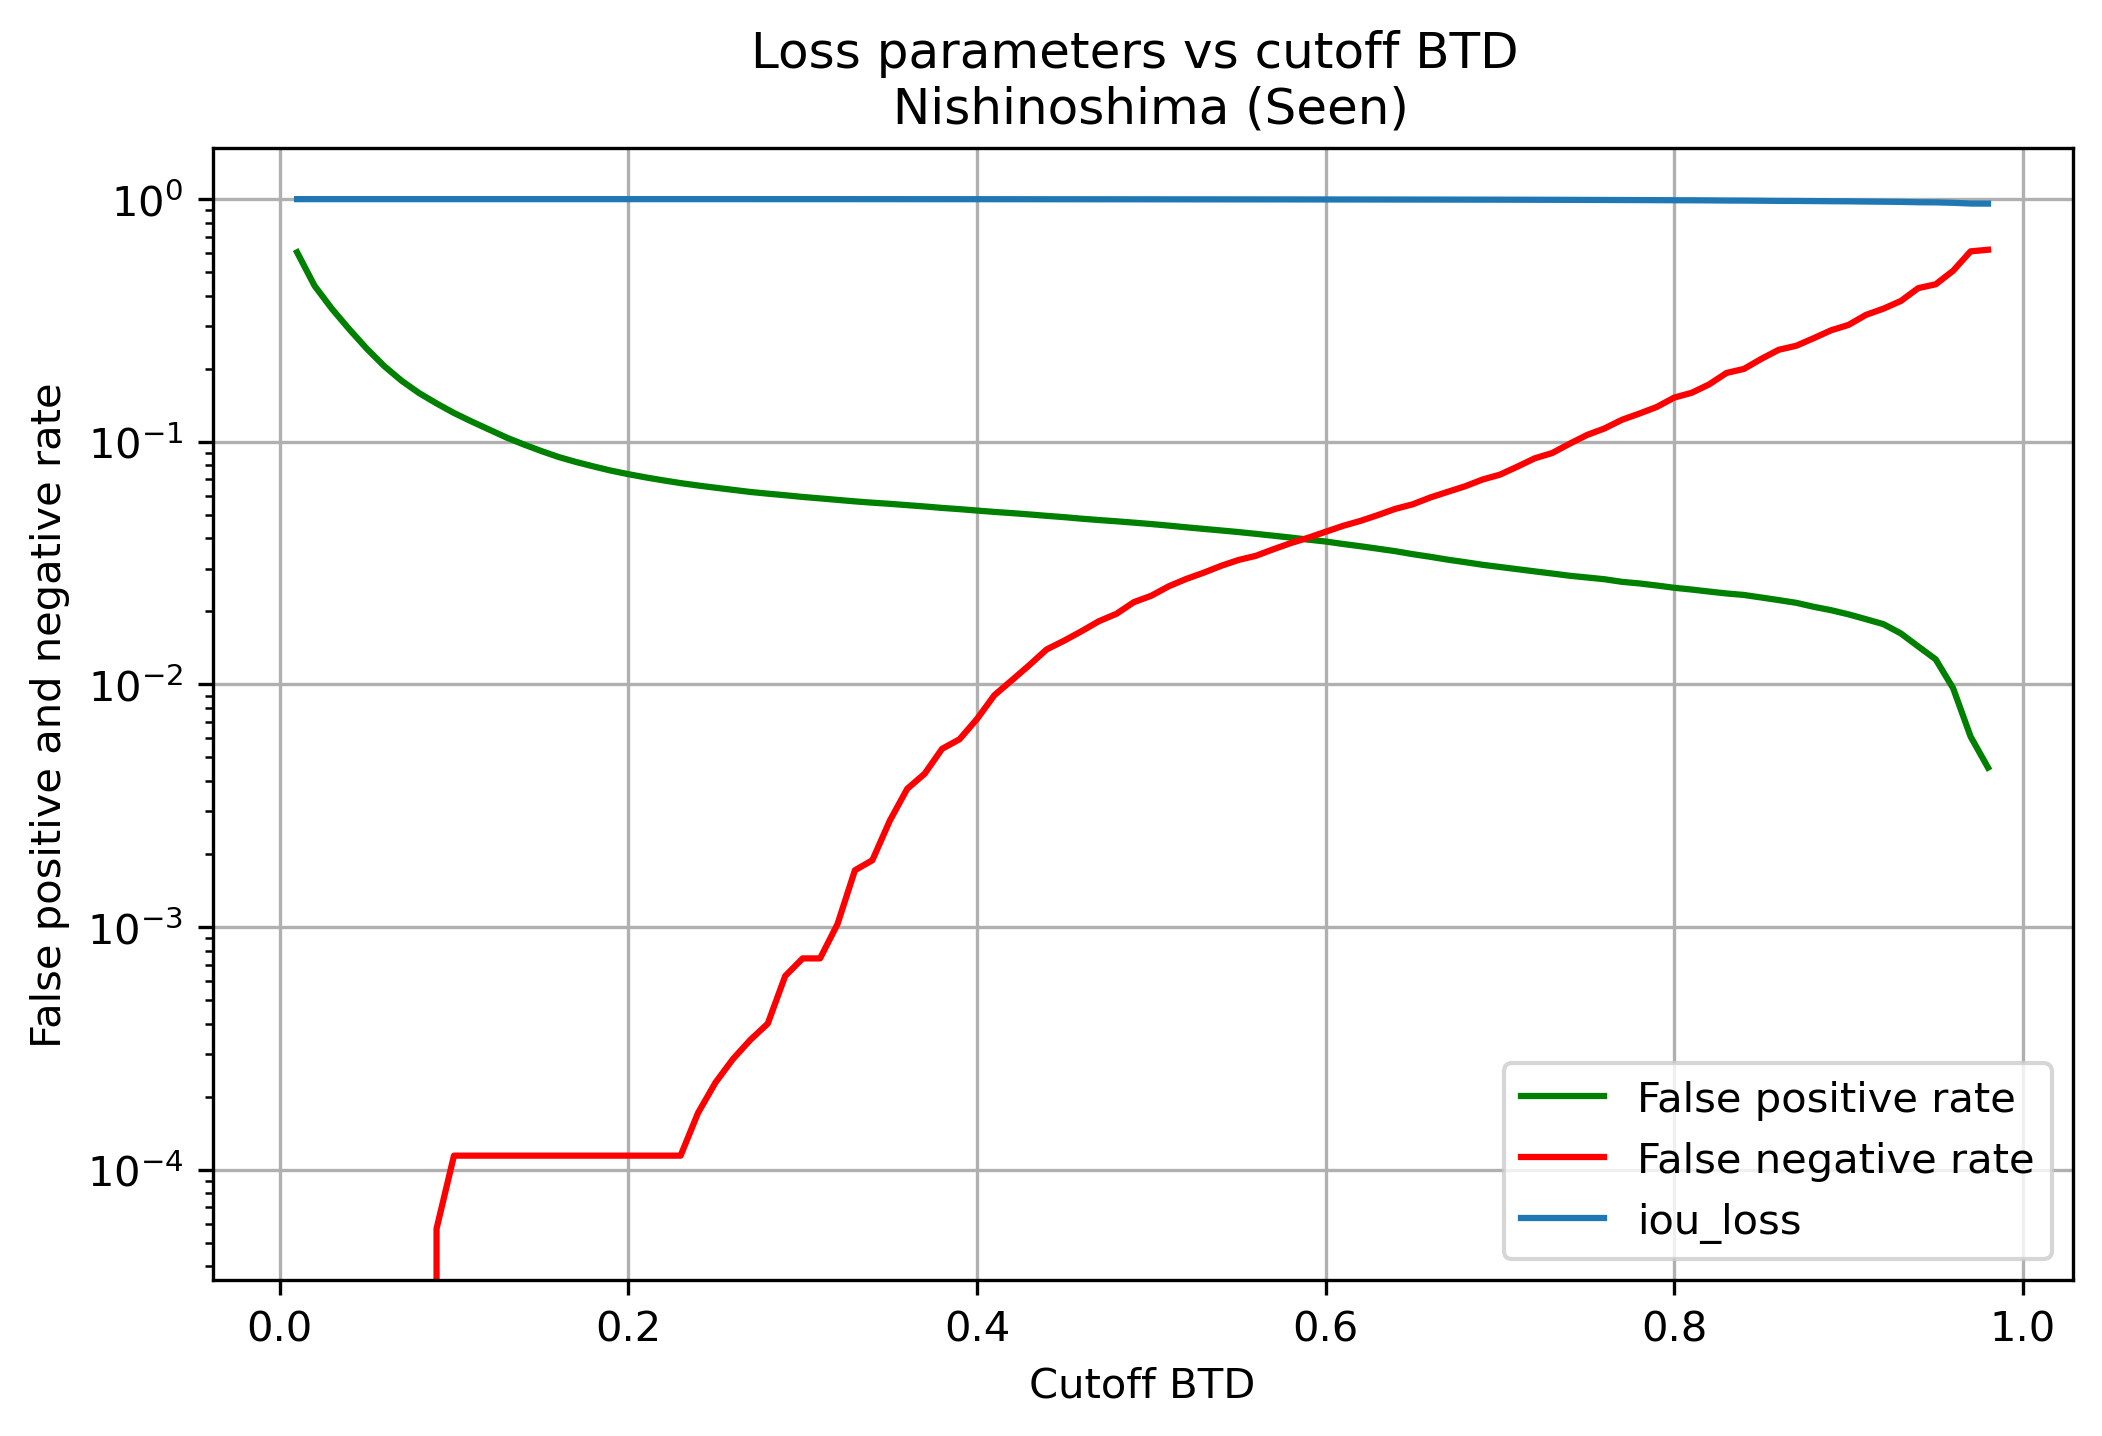

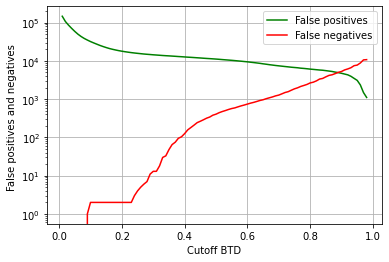

In [107]:
plt.figure(figsize=(8,5), dpi = 300)
plt.plot(trial_probs, list(zip(*false_rates_vec))[0] , "g-", label = "False positive rate")
plt.plot(trial_probs, list(zip(*false_rates_vec))[1] , "r-", label = "False negative rate")
#plt.plot(trial_probs, [sum(x) for x in zip(list(zip(*false_rates_vec))[0], list(zip(*false_rates_vec))[1])] , "b-", label = "Sum")
plt.plot(trial_probs, iou_vec , "-", label = "iou_loss")
plt.xlabel("Cutoff BTD")
plt.ylabel("False positive and negative rate")
plt.title("Loss parameters vs cutoff BTD \n Nishinoshima (Seen)")
plt.yscale("log")
plt.legend()
plt.grid()
#plt.show()
plt.savefig("Loss_parameters_Nishinoshima_BTD.png")
print(f"False positive rate at 85% threshold: {np.round(list(zip(*false_rates_vec))[0][84],4)}")
print(f"False positive rate at 50% threshold: {np.round(list(zip(*false_rates_vec))[0][49],4)}")
print(f"False negative rate at 85% threshold: {np.round(list(zip(*false_rates_vec))[1][84],4)}")
print(f"False negative rate at 50% threshold: {np.round(list(zip(*false_rates_vec))[1][49],4)}")


plt.figure()
plt.plot(trial_probs, list(zip(*false_rates_vec))[2] , "g-", label = "False positives")
plt.plot(trial_probs, list(zip(*false_rates_vec))[3] , "r-", label = "False negatives")
#plt.plot(trial_probs, [sum(x) for x in zip(list(zip(*false_rates_vec))[0], list(zip(*false_rates_vec))[1])] , "b-", label = "Sum")
plt.xlabel("Cutoff BTD")
plt.ylabel("False positives and negatives ")
#plt.title("Loss parameters vs cutoff probability \n Raikoke 2019/06/22 05:20 UTC (Seen)")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()


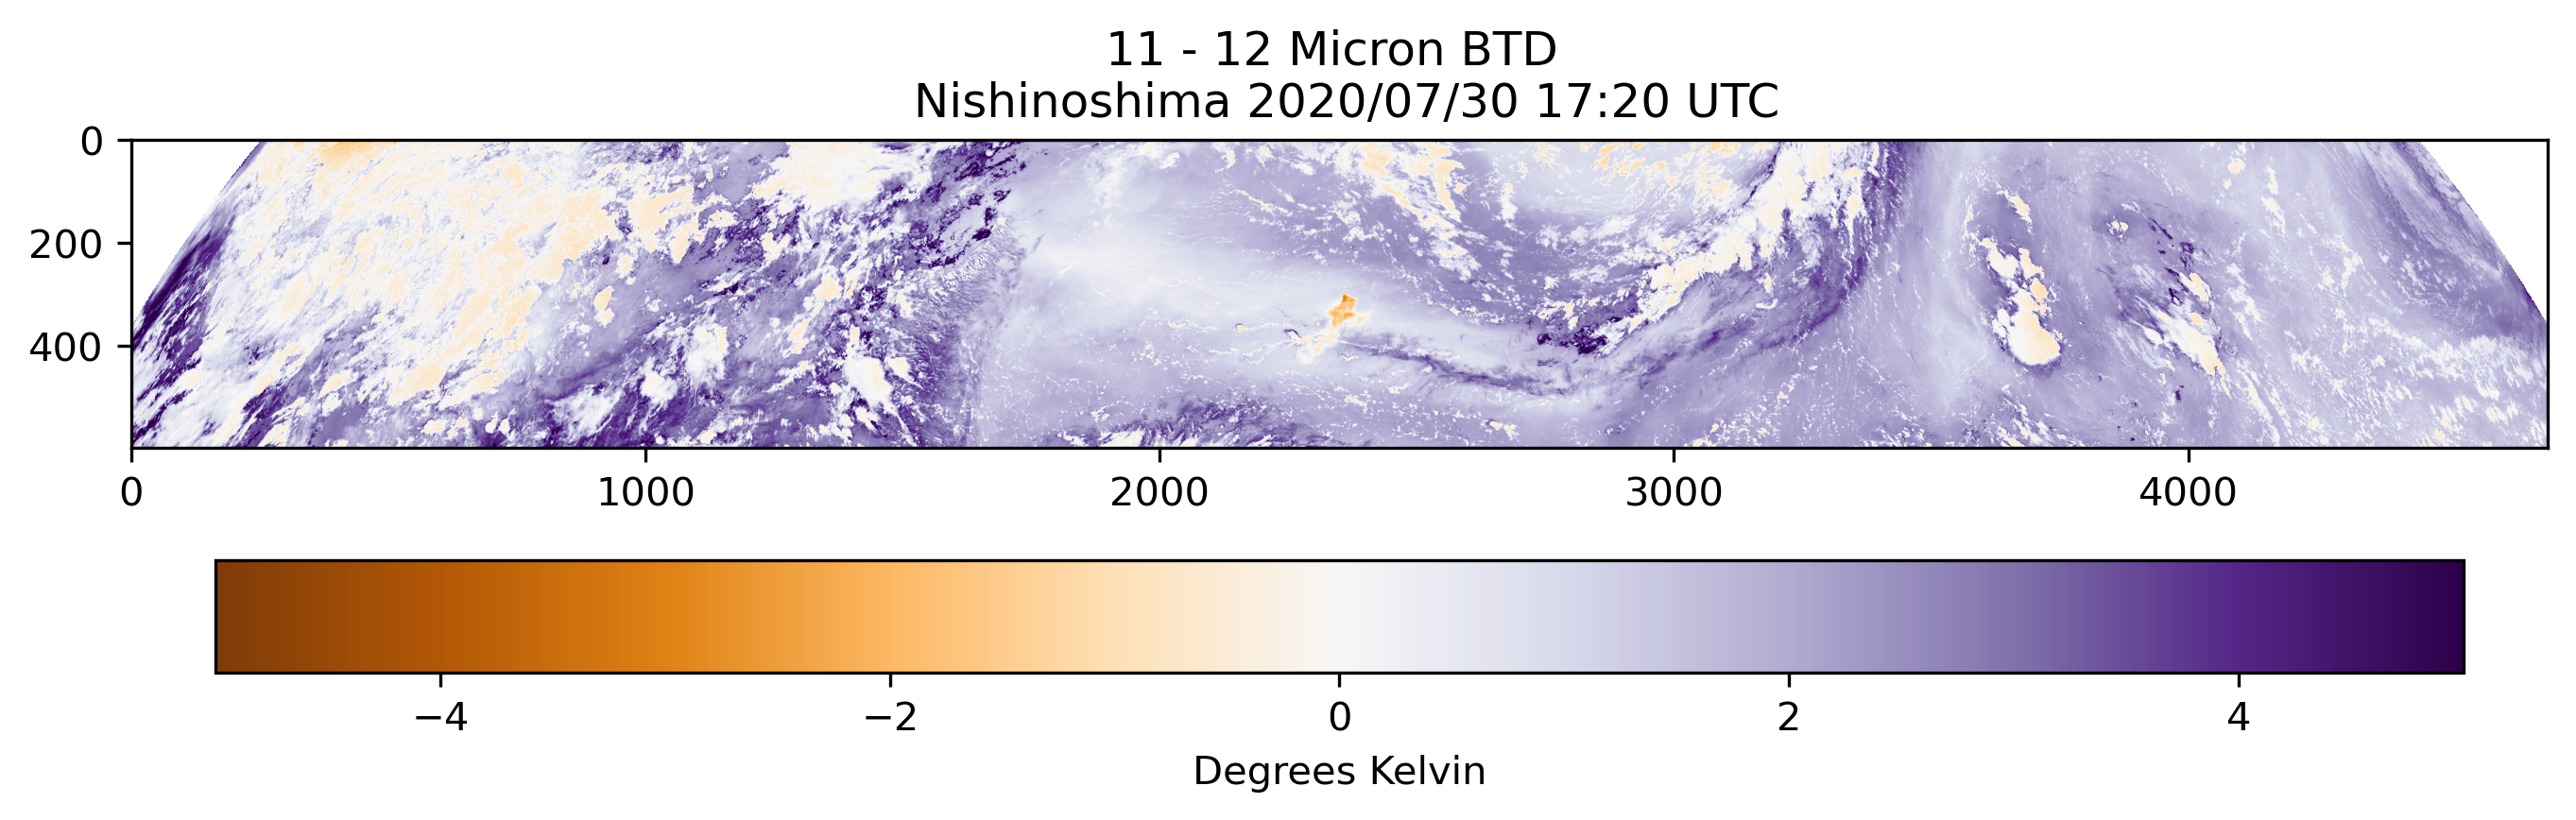

In [27]:
my_array = np.load("E:\\Nishinoshima\\Wide_arrays\\20200730_1720.npy")
#my_array = generate_ash_map_from_prob(my_array,0.65)
#my_array = my_array[:,:,13]
my_btd = (my_array[:,:,13]-my_array[:,:,14]) - np.exp(6. * (my_array[:,:,13] / 293) - (6-np.log(2.3)))
#my_array = -generate_ash_map_from_btd(my_btd,0.0)
plt.figure(figsize = (11,3.5), dpi = 300)
plt.title("11 - 12 Micron BTD \n Nishinoshima 2020/07/30 17:20 UTC")
plt.imshow(my_btd, cmap = "PuOr", vmin = -5, vmax = 5)
clb = plt.colorbar(orientation = "horizontal")
clb.set_label("Degrees Kelvin")
plt.savefig("Nishonishima_BTD_wide.png")

In [37]:
file_list = glob.glob("E:\\NEW_TRAINING\\*.npy")
ash_count_list_NISHINOSHIMA = []
ash_count_list_KARYMSKY = []
ash_count_list_KLYUCHEVSKOY = []
ash_count_list_SAKURAJIMA = []
ash_count_list_SHEVELUCH = []
ash_count_list_SUWANOSEJIMA = []
for idx, file in enumerate(file_list):
    print(f"Processing file {idx+1} of {len(file_list)}")
    volc_name = file.split("\\")[2][:-18]
    if volc_name == "NISHINOSHIMA":
        array = np.load(file)
        ash_count = np.nansum(array[:,:,16])
        ash_count_list_NISHINOSHIMA.append(ash_count)
    if volc_name == "KARYMSKY":
        array = np.load(file)
        ash_count = np.nansum(array[:,:,16])
        ash_count_list_KARYMSKY.append(ash_count)
    if volc_name == "KLYUCHEVSKOY":
        array = np.load(file)
        ash_count = np.nansum(array[:,:,16])
        ash_count_list_KLYUCHEVSKOY.append(ash_count)
    if volc_name == "SAKURAJIMA (AIRA CALDERA)":
        array = np.load(file)
        ash_count = np.nansum(array[:,:,16])
        ash_count_list_SAKURAJIMA.append(ash_count)
    if volc_name == "SHEVELUCH":
        array = np.load(file)
        ash_count = np.nansum(array[:,:,16])
        ash_count_list_SHEVELUCH.append(ash_count)
    if volc_name == "SUWANOSEJIMA":
        array = np.load(file)
        ash_count = np.nansum(array[:,:,16])
        ash_count_list_SUWANOSEJIMA.append(ash_count)

combined_ash_count_list = [ash_count_list_NISHINOSHIMA, ash_count_list_KARYMSKY,
                           ash_count_list_KLYUCHEVSKOY, ash_count_list_SAKURAJIMA,
                           ash_count_list_SHEVELUCH, ash_count_list_SUWANOSEJIMA]

Processing file 1 of 968
Processing file 2 of 968
Processing file 3 of 968
Processing file 4 of 968
Processing file 5 of 968
Processing file 6 of 968
Processing file 7 of 968
Processing file 8 of 968
Processing file 9 of 968
Processing file 10 of 968
Processing file 11 of 968
Processing file 12 of 968
Processing file 13 of 968
Processing file 14 of 968
Processing file 15 of 968
Processing file 16 of 968
Processing file 17 of 968
Processing file 18 of 968
Processing file 19 of 968
Processing file 20 of 968
Processing file 21 of 968
Processing file 22 of 968
Processing file 23 of 968
Processing file 24 of 968
Processing file 25 of 968
Processing file 26 of 968
Processing file 27 of 968
Processing file 28 of 968
Processing file 29 of 968
Processing file 30 of 968
Processing file 31 of 968
Processing file 32 of 968
Processing file 33 of 968
Processing file 34 of 968
Processing file 35 of 968
Processing file 36 of 968
Processing file 37 of 968
Processing file 38 of 968
Processing file 39 of

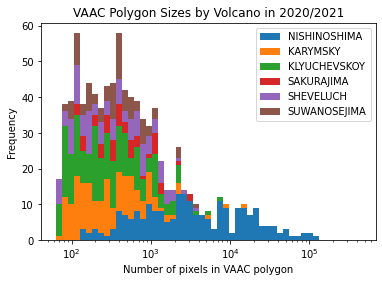

In [38]:
bins = 2**(np.arange(6,19,0.25))
plt.hist(combined_ash_count_list, stacked=True,
         label=["NISHINOSHIMA",'KARYMSKY','KLYUCHEVSKOY','SAKURAJIMA','SHEVELUCH', 'SUWANOSEJIMA'], bins = bins)
plt.xscale("log")
plt.xlabel("Number of pixels in VAAC polygon")
plt.ylabel("Frequency")
plt.title("VAAC Polygon Sizes by Volcano in 2020/2021")
plt.legend()
plt.savefig("VAAC_POLYGON_SIZES.png")


